In [1]:
# Install the Prophet
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from prophet import Prophet
import yfinance as yf
import os
import csv

In [3]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
# Set crypto variable
crypto = 'AVAX'
yf_crypto = 'AVAX'

# Set YF crypto symbol
symbol = f'{yf_crypto}-USD'

# Create crypto df
#crypto_df = f'{crypto}_df'.lower()

In [5]:
# Retreive max data
data = yf.Ticker(f'{symbol}')
history = data.history(period='max')

# Define file path and name
#filepath = f'~/crypto-forecast/resources/{crypto}-USD.csv'
#filepath = os.path.expanduser('~/crypto-forecast/resources/ADA-USD.csv')

# Create dataframe
crypto_df = pd.DataFrame(history)

# Set 'Date' as the index and parse dates
crypto_df.index = pd.to_datetime(crypto_df.index)

# Drop columns
crypto_df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

# Drop last row
crypto_df = crypto_df.drop(crypto_df.tail(1).index)

# Drop rows with any NaN values
crypto_df.dropna(inplace=True)

# Sort by ascending date
crypto_df = crypto_df.sort_values(by="Date", ascending=True)

# Drop timezone from datetime
crypto_df = crypto_df.reset_index()
crypto_df['Date'] = crypto_df['Date'].dt.tz_localize(None)
crypto_df.set_index('Date', inplace=True)

# Set file path to store data as a csv
csv_filepath = os.path.expanduser(f'~/crypto-forecast/resources/{crypto}-USD.csv')

# Write the DataFrame to a CSV file
crypto_df.to_csv(csv_filepath, index=True)

# Review the first and last five rows of the DataFrame
display(crypto_df.head())
display(crypto_df.tail())

,Open,High,Low,Close,Volume
Date,,,,,
2020-07-13,4.613968,4.915115,4.481499,4.896294,28340
2020-07-14,4.909865,5.229564,4.762068,4.986754,3957
2020-09-22,4.986754,11.463443,4.125380,5.234632,288098840
2020-09-23,5.321654,5.329310,3.982604,4.118469,173091214
2020-09-24,3.817925,4.751878,3.539887,4.566561,96110964


,Open,High,Low,Close,Volume
Date,,,,,
2024-06-04,35.040466,36.229015,34.571976,36.073288,331619265
2024-06-05,36.073288,36.876366,35.980949,36.521587,338905421
2024-06-06,36.521896,37.143639,35.780071,35.911816,288389895
2024-06-07,35.911819,36.826385,31.625736,33.507790,639619595
2024-06-08,33.506649,33.695019,31.995676,32.290031,283275581


In [6]:
# Get last closing price
last_close_df = crypto_df.iloc[-1]
last_close_price = last_close_df['Close']
last_close_price

32.29003143310547

In [7]:
crypto_df.corr()

,Open,High,Low,Close,Volume
Open,1.000000,0.997308,0.996978,0.994695,0.712708
High,0.997308,1.000000,0.996248,0.997819,0.736263
Low,0.996978,0.996248,1.000000,0.997229,0.702702
Close,0.994695,0.997819,0.997229,1.000000,0.724885
Volume,0.712708,0.736263,0.702702,0.724885,1.000000


In [8]:
# Create new df with just Close prices and Volume
df_close = crypto_df[['Close', 'Volume']]

In [9]:
df_close.name = 'Close'
df_close

,Close,Volume
Date,,
2020-07-13,4.896294,28340
2020-07-14,4.986754,3957
2020-09-22,5.234632,288098840
2020-09-23,4.118469,173091214
2020-09-24,4.566561,96110964
...,...,...
2024-06-04,36.073288,331619265
2024-06-05,36.521587,338905421
2024-06-06,35.911816,288389895


In [10]:
# Create a copy of the DataFrame to avoid the SettingWithCopyWarning
df_close_ma = df_close.copy()

# Calculate 10-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA10'] = df_close_ma['Close'].rolling(10).mean()

# Calculate 30-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA30'] = df_close_ma['Close'].rolling(30).mean()

# Calculate 50-day Simple Moving Average (SMA)
df_close_ma.loc[:, 'SMA50'] = df_close_ma['Close'].rolling(50).mean()

# Remove NULL values
df_close_ma.dropna(inplace=True)

In [11]:
# Review the first and last five rows of the DataFrame
display(df_close_ma.head())
display(df_close_ma.tail())

,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2020-11-08,3.476598,26072941,3.502076,3.918005,4.061066
2020-11-09,3.417125,25509378,3.472294,3.897685,4.031483
2020-11-10,3.586142,24316551,3.466072,3.880694,4.003471
2020-11-11,3.484356,24727644,3.446241,3.849648,3.968465
2020-11-12,3.429143,25090677,3.426764,3.814351,3.954679


,Close,Volume,SMA10,SMA30,SMA50
Date,,,,,
2024-06-04,36.073288,331619265,36.196848,36.082191,35.866569
2024-06-05,36.521587,338905421,36.173802,36.061632,35.901677
2024-06-06,35.911816,288389895,35.941552,36.080634,35.948988
2024-06-07,33.507790,639619595,35.592791,36.062654,35.922127
2024-06-08,32.290031,283275581,35.208102,35.969633,35.873478


<Axes: xlabel='Date'>

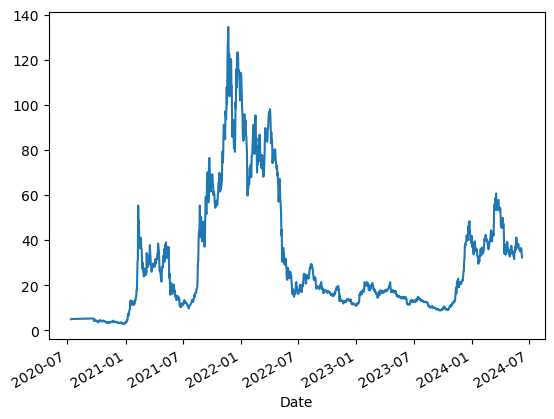

In [12]:
# Plot Close
df_close['Close'].plot()

In [13]:
## Create a Time Series Model with Prophet

In [14]:
# Using the DataFrame, reset the index so the date information is no longer the index
df_close = df_close.reset_index()

In [15]:
# Label the columns ds and y so that the syntax is recognized by Prophet
df_close.rename(columns={'Date':'ds','Close':'y'}, inplace=True)

# Drop an NaN values from the prophet_df DataFrame
df_close.dropna()

# View the first and last five rows of the DataFrame
df_close

,ds,y,Volume
0,2020-07-13,4.896294,28340
1,2020-07-14,4.986754,3957
2,2020-09-22,5.234632,288098840
3,2020-09-23,4.118469,173091214
4,2020-09-24,4.566561,96110964
...,...,...,...
1353,2024-06-04,36.073288,331619265
1354,2024-06-05,36.521587,338905421
1355,2024-06-06,35.911816,288389895
1356,2024-06-07,33.507790,639619595


In [16]:
# Call the Prophet function, store as an object
crypto_model = Prophet()

In [17]:
# Fit the time-series model.
crypto_model.fit(df_close)

16:32:07 - cmdstanpy - INFO - Chain [1] start processing
16:32:07 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Create a future dataframe to hold predictions
# Make the prediction go out 30 days
crypto_future = crypto_model.make_future_dataframe(periods = 90, freq = 'd')

# View the last five rows of the DataFrame
crypto_future.tail(5)

,ds
1443,2024-09-02
1444,2024-09-03
1445,2024-09-04
1446,2024-09-05
1447,2024-09-06


In [19]:
# Make the predictions for the data using the DataFrame
crypto_forecast = crypto_model.predict(crypto_future)

# Display the first five rows of the DataFrame
crypto_forecast.tail(30)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1418,2024-08-08,40.947566,20.277812,41.441693,38.022127,43.931080,-10.693308,-10.693308,-10.693308,-0.040208,-0.040208,-0.040208,-10.653100,-10.653100,-10.653100,0.0,0.0,0.0,30.254258
1419,2024-08-09,41.009061,20.134048,40.919444,37.971731,44.047413,-10.464429,-10.464429,-10.464429,-0.075439,-0.075439,-0.075439,-10.388991,-10.388991,-10.388991,0.0,0.0,0.0,30.544632
1420,2024-08-10,41.070557,20.673466,41.779637,37.910363,44.210301,-9.970189,-9.970189,-9.970189,0.142078,0.142078,0.142078,-10.112267,-10.112267,-10.112267,0.0,0.0,0.0,31.100368
1421,2024-08-11,41.132053,20.563250,41.768152,37.865354,44.381551,-9.896527,-9.896527,-9.896527,-0.068876,-0.068876,-0.068876,-9.827652,-9.827652,-9.827652,0.0,0.0,0.0,31.235526
1422,2024-08-12,41.193549,20.157095,42.813616,37.815246,44.539320,-9.600226,-9.600226,-9.600226,-0.060262,-0.060262,-0.060262,-9.539964,-9.539964,-9.539964,0.0,0.0,0.0,31.593323
1423,2024-08-13,41.255045,21.164042,42.648893,37.681660,44.693604,-9.289156,-9.289156,-9.289156,-0.035165,-0.035165,-0.035165,-9.253991,-9.253991,-9.253991,0.0,0.0,0.0,31.965888
1424,2024-08-14,41.316541,21.992073,43.350065,37.633312,44.871117,-8.836491,-8.836491,-8.836491,0.137872,0.137872,0.137872,-8.974363,-8.974363,-8.974363,0.0,0.0,0.0,32.480050
1425,2024-08-15,41.378037,22.564662,43.452161,37.518778,45.038634,-8.745636,-8.745636,-8.745636,-0.040208,-0.040208,-0.040208,-8.705428,-8.705428,-8.705428,0.0,0.0,0.0,32.632400
1426,2024-08-16,41.439532,21.765272,44.480871,37.379972,45.202484,-8.526580,-8.526580,-8.526580,-0.075439,-0.075439,-0.075439,-8.451141,-8.451141,-8.451141,0.0,0.0,0.0,32.912953
1427,2024-08-17,41.501028,22.077018,44.022017,37.320407,45.403707,-8.072883,-8.072883,-8.072883,0.142078,0.142078,0.142078,-8.214961,-8.214961,-8.214961,0.0,0.0,0.0,33.428145


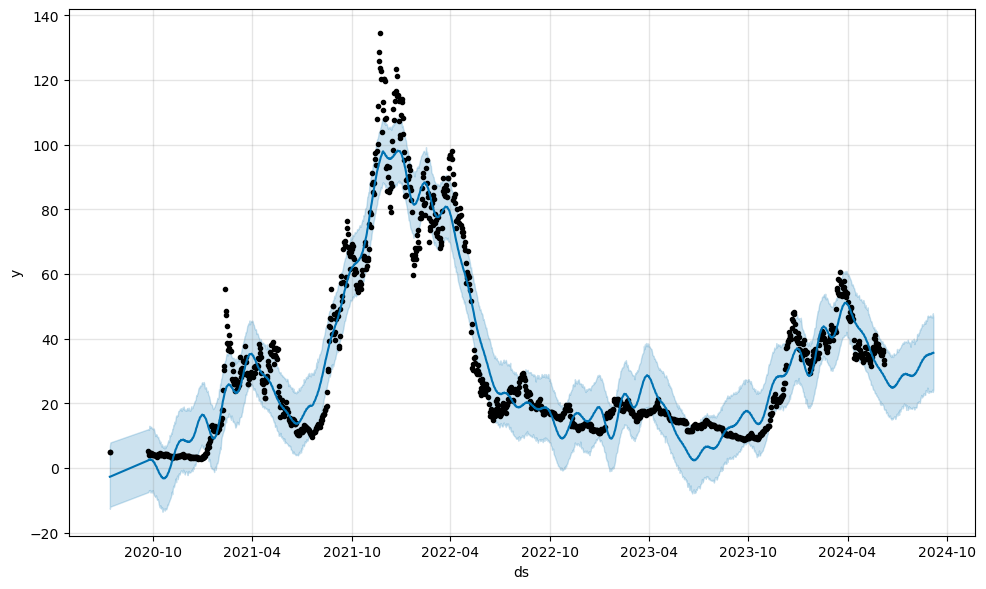

In [20]:
# Plot the Prophet predictions for the data
crypto_model.plot(crypto_forecast)
plt.savefig(f'{crypto}_forecast', bbox_inches = 'tight')

In [21]:
# Set the index in the forecast DataFrame to the ds datetime column
crypto_forecast = crypto_forecast.set_index('ds')

In [22]:
# View only the yhat,yhat_lower and yhat_upper columns from the forecast DataFrame
crypto_forecast[['yhat', 'yhat_lower', 'yhat_upper']].iloc[-90:,:]

,yhat,yhat_lower,yhat_upper
ds,,,
2024-06-09,27.727540,17.956270,37.578888
2024-06-10,27.426072,18.081575,37.451896
2024-06-11,27.141240,16.921703,36.892457
2024-06-12,27.007961,17.217097,36.533475
2024-06-13,26.530993,17.108716,36.558097
...,...,...,...
2024-09-02,35.237041,23.530430,46.584459
2024-09-03,35.332582,23.823148,46.968539
2024-09-04,35.590456,24.219667,46.521276


In [23]:
# Rename columns
crypto_forecast.rename(columns={'yhat':'mid trend price','yhat_lower':'lower trend price','yhat_upper':'upper trend price'}, inplace=True)

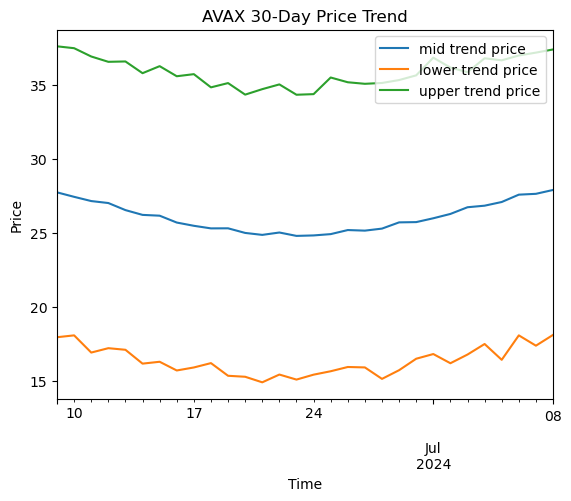

In [24]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-60,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 30-Day Price Trend')    
plt.show()

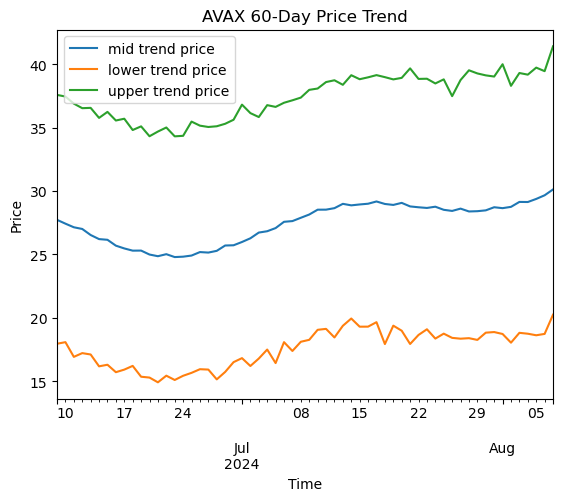

In [25]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:-30,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 60-Day Price Trend')    
plt.show()

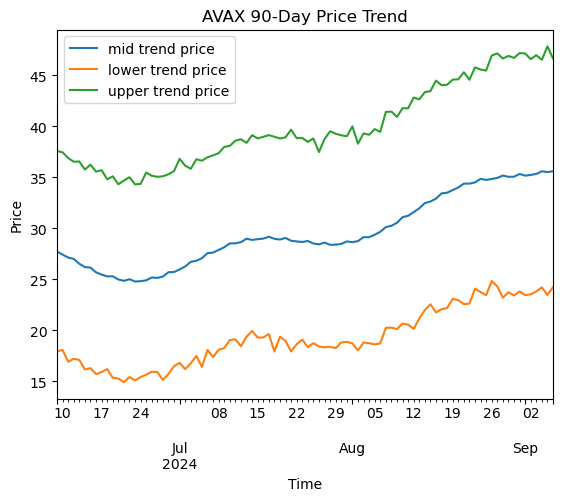

In [26]:
# From the forecast DataFrame, plot the data to visualize
# the yhat, yhat_lower, and yhat_upper columns over the last 30 days
crypto_forecast[['mid trend price', 'lower trend price', 'upper trend price']].iloc[-90:,:].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} 90-Day Price Trend')    
plt.savefig(f'{crypto}_90d_trend_forecast', bbox_inches = 'tight')
plt.show()

In [27]:
# Retrieve last closing price
last_close_price

32.29003143310547

In [28]:
# Retreive tomorrow's mid trend price forecast
tommorow_mid_trend_price = crypto_forecast['mid trend price'].iloc[-90]
tommorow_mid_trend_price

27.727539512527844

In [29]:
# Calculate tommorrow's weighted price
wp = last_close_price*.5 + tommorow_mid_trend_price*.5
wp

30.008785472816655

In [30]:
# Retreive tomorrow's weighted trend price forecast
tommorow_mid_trend_price = ((crypto_forecast['mid trend price'].iloc[-90]*.6)+(crypto_forecast['upper trend price'].iloc[-90]*.2)+(crypto_forecast['lower trend price'].iloc[-90]*.2))
tommorow_mid_trend_price

27.74355513738827

In [31]:
# Retrieve weighted trend price in 30 days
mid_trend_price_in_30 = ((crypto_forecast['mid trend price'].iloc[-60]*.6)+(crypto_forecast['upper trend price'].iloc[-60]*.2)+(crypto_forecast['lower trend price'].iloc[-60]*.2))
mid_trend_price_in_30

28.13677601203395

In [32]:
# Retrieve weighted trend price in 60 days
mid_trend_price_in_60 = ((crypto_forecast['mid trend price'].iloc[-30]*.6)+(crypto_forecast['upper trend price'].iloc[-30]*.2)+(crypto_forecast['lower trend price'].iloc[-30]*.2))
mid_trend_price_in_60

30.496455413837484

In [33]:
# Retrieve weighted trend price in 90 days
mid_trend_price_in_90 = ((crypto_forecast['mid trend price'].iloc[-1]*.6)+(crypto_forecast['upper trend price'].iloc[-1]*.2)+(crypto_forecast['lower trend price'].iloc[-1]*.2))
mid_trend_price_in_90

35.54015451883401

In [34]:
# Calculate expected gain/loss between mid trend price in 30 days and last close price
#percent_diff_30 = ((mid_trend_price_in_30)/(last_close_price))-1
percent_diff_30 = ((mid_trend_price_in_30)/(wp))-1
percent_diff_30.round(3)

-0.062

In [35]:
# Calculate expected gain/loss between mid trend price in 60 days and last close price
#percent_diff_60 = ((mid_trend_price_in_60)/(last_close_price))-1
percent_diff_60 = ((mid_trend_price_in_60)/(wp))-1
percent_diff_60.round(3)

0.016

In [36]:
# Calculate expected gain/loss between mid trend price in 90 days and last close price
#percent_diff_90 = ((mid_trend_price_in_90)/(last_close_price))-1
percent_diff_90 = ((mid_trend_price_in_90)/(wp))-1
percent_diff_90.round(3)

0.184

In [37]:
# Reset the index in the forecast DataFrame
crypto_forecast = crypto_forecast.reset_index()

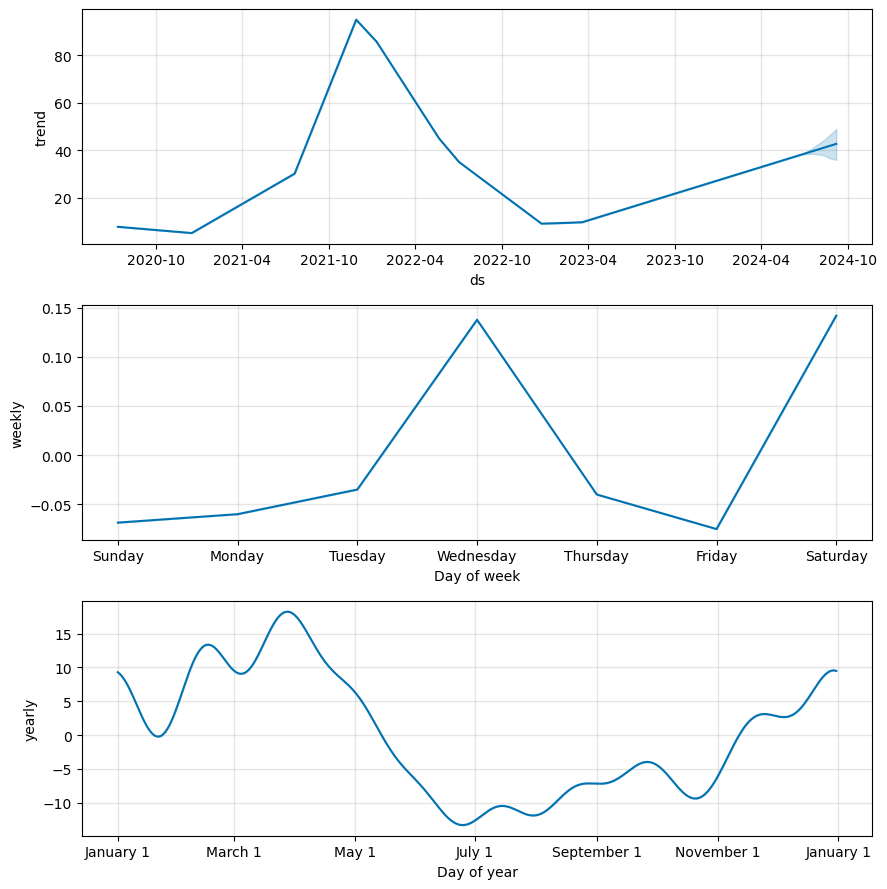

In [38]:
# Use the plot_components function to visualize the forecast results
# for the forecast DataFrame
fig_comp = crypto_model.plot_components(crypto_forecast)
plt.savefig(f'{crypto}_components.png', bbox_inches = 'tight')

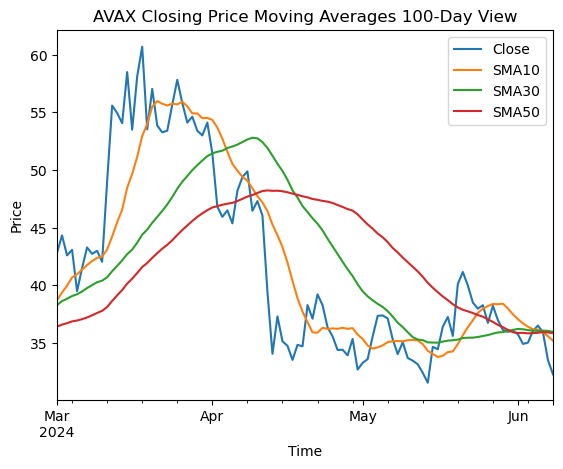

In [39]:
df_last_100 = df_close_ma.iloc[-100:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 100-Day View')    
plt.show()

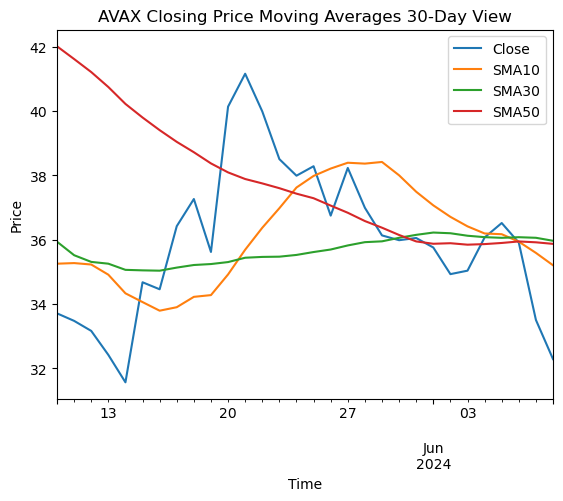

In [40]:
df_last_100 = df_close_ma.iloc[-30:]
df_last_100[['Close', 'SMA10', 'SMA30', 'SMA50']].plot()
plt.xlabel('Time')
plt.ylabel('Price')
plt.title(f'{crypto} Closing Price Moving Averages 30-Day View')   
plt.savefig(f'{crypto}_30d_MA_view.png', bbox_inches = 'tight')
plt.show()

In [41]:
# import module
from datetime import datetime
 
# get current date and time
current_datetime = datetime.now().strftime("%Y-%m-%d")
print("Current date & time : ", current_datetime)
 
# convert datetime obj to string
str_current_datetime = str(current_datetime)
 
# create a file object along with extension
#file_name = f'{crypto} '+str_current_datetime+".txt"
file_name = str_current_datetime+".csv"
file = open(file_name, 'a')
 
print("File created : ", file.name)
file.close()

Current date & time :  2024-06-09
File created :  2024-06-09.csv


In [42]:
f = open(f'{file_name}', "a")
f.writelines([f'{crypto},{last_close_price},{percent_diff_30},{percent_diff_60},{percent_diff_90}\n'])
f.close()

In [43]:
f = open(f'{file_name}', "r")
print(f.read())

ADA,0.43657100200653076,-0.07364667494769794,-0.0009456964793739253,0.3544596118546628
ADA,0.43657100200653076,-0.08437373181845453,0.002834181787628731,0.36173019111251126
ADA,0.43657100200653076,-0.08372637062435029,0.0025919668069758206,0.3631142967037635
ADA,0.43657100200653076,-0.0783190338427533,0.004381382002310641,0.36321329122708335
ATOM,7.759523868560791,-0.2525451407294217,-0.22995154564524733,0.08676291965413196
AVAX,32.29003143310547,-0.06238204683353343,0.016250905637703372,0.184324988794629

